In [ ]:
#GOAL: Produce nice potential figure for RDA paper showing climatological YEARLY rainfall totals over wide area
#then, in panels b and c, show changes between '51-'79 and '80-'07, and then '80-'93 and '94-'07

In [1]:
import numpy as np
import numpy.ma as ma
import time
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib notebook
from shutil import copyfile

In [2]:
ferretdatapath = "/Users/Siwen/Desktop/ferret/fer_dsets/data/"
aphropath = "APHRO_MA_025deg_V1101."
years = np.arange(1951,2008)
print(years)

[1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965
 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980
 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007]


In [3]:
P_asia_year = np.zeros((280,360,57))

In [6]:
for i in years:
    
    #Build filename
    filename = ferretdatapath + aphropath + str(i) + '.nc'
    print(filename)
    myf = nc.Dataset(filename, 'r')
    
    #Obtain fraction of different types of rainfall
    P =  myf.variables['precip'][:]

    #Find seasonal amounts of each type of rainfall
    yr=i-1951
    
    #leaving out day 366 in leap years for convenience
    P_asia_year[:,:,yr]=np.nanmean(P[0:365,:,:], axis=0)
    
    #myf.close()
    


/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1951.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1952.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1953.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1954.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1955.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1956.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1957.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1958.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1959.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1960.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1961.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1962.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA_025deg_V1101.1963.nc
/Users/Siwen/Desktop/ferret/fer_dsets/data/APHRO_MA

In [22]:
P_asia_year_mask = ma.array(P_asia_year, mask = np.isnan(P_asia_year))
P_asia_year_sum = P_asia_year_mask * 365

myfilename = '/Users/Siwen/Desktop/Ferret/bin/P_asia_year.nc'

myfile = nc.Dataset(myfilename, 'w')

#SAVE EVERYTHING AS HANDY NETCDF FILE
long_dim = myfile.createDimension('long', 360)
lat_dim = myfile.createDimension('lat', 280)
years_dim = myfile.createDimension('years', None)

dim_tuple = ("lat","long","years")
P_asia = myfile.createVariable("P_asia_year", 'f8', dim_tuple)
P_asia_sum = myfile.createVariable("P_asia_year_sum", 'f8', dim_tuple)

P_asia[:] = P_asia_year_mask
P_asia_sum[:] = P_asia_year_sum

myfile.close()
    

In [19]:
#years of interest - start and end date, with index starting at 1 out of habit.
myfilename = '/Users/Siwen/Desktop/Ferret/bin/P_asia_year.nc'

rainfile = nc.Dataset(myfilename, 'r')


p1_yr_b = [1,30]
p1_yr_e = [29,43]
p2_yr_b = [30,44]
p2_yr_e = [57,57]

P_asia_diff = []
P_asia_sum_diff = []

#cycle through all time periods of interest and find changes in each type of rainfall b/w periods
for p1_b, p1_e, p2_b, p2_e, i in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 
    
    P_asia_diff.append(np.mean(P_asia_year_mask[:,:,p2_b-1:p2_e], axis=2) - \
                         np.mean(P_asia_year_mask[:,:,p1_b-1:p1_e], axis=2))
    
    P_asia_sum_diff.append(np.mean(P_asia_year_mask[:,:,p2_b-1:p2_e], axis=2) - \
                         np.mean(P_asia_year_mask[:,:,p1_b-1:p1_e], axis=2))


<IPython.core.display.Javascript object>


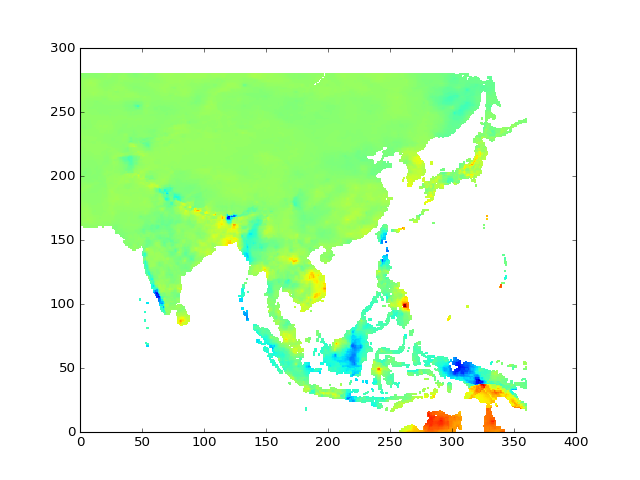

In [45]:
#BOOTSTRAPPING

#similar to china_rain_diff, do lots of bootstrapping at each spatial point.

#daysmth is defined above
niter = 100 #how many iterations each time?
filepath = "asia_rain_diff_pval_"
backuppath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
yearsout = str(p1_b+50) + str(p1_e+50) + "_" + str(p2_b+50) + str(p2_e+50) + "_"
fullname = filepath + str(niter) + "iter.nc"
backupname = backuppath + fullname

##the following is only to make sure that we don't exceed the bounds of the number of rows of actual data.
if os.path.isfile(fullname):

    print('WARNING - file already exists! Cannot overwrite.')
    return
            
print('Building new file.')
fileout = nc.Dataset(savefile, 'w')
long_dim = fileout.createDimension('long', 360)
lat_dim = fileout.createDimension('lat', 280)
record_dim = fileout.createDimension('records', None)

dim_tuple = ("lat","long","record")
pval_8007_5179 = fileout.createVariable("pval_8007_5179", 'f8', dim_tuple)
pval_9407_8093 = fileout.createVariable("pval_9407_8093", 'f8', dim_tuple)
    
pvals=np.array.zeros(360,280,2)
    
#P-VALUES OF TOTAL RAINFALL
for p1_b, p1_e, p2_b, p2_e, k in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 

    for i in range(360):
    
        for j in range(280):
    
            if ma.getmask(P_asia_year_mask[i,j,0]) == 0:
                pvals[i,j,k] = bs_means_diff([i,j,p1_b-1:p1_e],[i,j,p2_b-1:p2_e], niter)

    #backup to external directory
        if os.path.exists(backupname):
            os.remove(backupname)
        copyfile(fullname, backupname) #backs file up in case of corruption

In [49]:
ma.getmask(P_asia_year_mask[0,:,0])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,